# **PhoRC**: **Pho**tocurrent **R**emoval with **C**onstraints

This notebook demonstrates how to estimate and subtract photocurrents on simulated data using the PhoRC package.
First, we import some relevant packages and configure matplotlib for nicer plots.

In [1]:
import phorc
import phorc.utils as utils
import jax.random as jrand
from phorc.simulation import sample_photocurrent_experiment

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams.update({'font.size': 7, 'lines.markersize': np.sqrt(5), 'lines.linewidth': 0.5, 'lines.markeredgewidth': 0.25})
plt.rc('font', family='Helvetica')

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

sns.set_palette('deep')

### Simulated data 1: Adjust parameters using sliders

The below code allows the user to adjust four variables:
- adjusting `tau_o` and `tau_r` controls the shape of the photocurrent waveform. 
- changing `random_seed` generates a new random experiment realization (with kinetics of the photocurrent fixed).
- changing `isi_ms` adjusts the inter-stimulus interval. Short value of this parameter will result in residual effects from prior trials. This can be used to explore how PhoRC behaves at different ISIs.

In [2]:
import ipywidgets as widgets

# Initialize the variables
tau_o = 8
tau_r = 11
random_seed = 0
isi_ms = 50

# Create sliders for each variable
tau_o_slider = widgets.FloatSlider(min=3, max=15, value=tau_o, description='tau_o')
tau_r_slider = widgets.FloatSlider(min=3, max=15, value=tau_r, description='tau_r')
random_seed_slider = widgets.IntSlider(min=0, max=5, value=random_seed, description='random_seed')
isi_ms_slider = widgets.IntSlider(min=30, max=60, value=isi_ms, description='isi_ms')

# Define a function that will be called when the sliders are moved
def update_tau_o(change):
    global tau_o
    tau_o = change['new']

def update_tau_r(change):
    global tau_r
    tau_r = change['new']

def update_random_seed(change):
    global random_seed
    random_seed = change['new']

def update_isi_ms(change):
    global isi_ms
    isi_ms = change['new']

# Add the function as an observer to the 'value' trait of the sliders
tau_o_slider.observe(update_tau_o, names='value')
tau_r_slider.observe(update_tau_r, names='value')
random_seed_slider.observe(update_random_seed, names='value')
isi_ms_slider.observe(update_isi_ms, names='value')

# Display the sliders
display(tau_o_slider, tau_r_slider, random_seed_slider, isi_ms_slider)


FloatSlider(value=8.0, description='tau_o', max=15.0, min=3.0)

FloatSlider(value=11.0, description='tau_r', max=15.0, min=3.0)

IntSlider(value=0, description='random_seed', max=5)

IntSlider(value=50, description='isi_ms', max=60, min=30)

### Simulated data 2: Generate data and plot
Run the the cell below to generate simulated intracellular traces containing a mixture of EPSCs and photocurrents. Note that this cell must be re-run if the values of the sliders above are changed.

After running this cell `observed`, `true_photo` and `true_synaptic` will be JAX devicearrays (similar to numpy arrays) containing observed traces, ground truth photocurrents, and ground truth EPSCs respectively. 

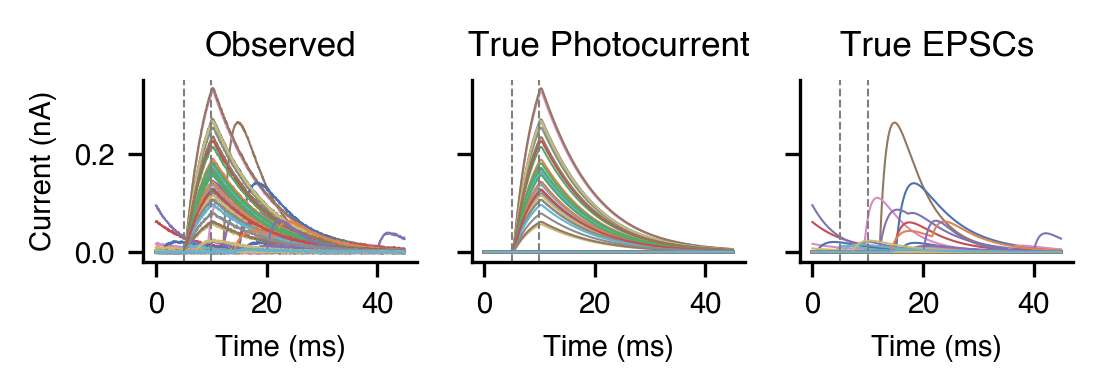

In [6]:


def generate_and_plot(tau_o, tau_r, random_seed, isi_ms, axs=None):
    
    key = jrand.PRNGKey(random_seed)
    pc_shape_params = dict(
           O_inf_min=0.3,
            O_inf_max=1.0,
            R_inf_min=0.1,
            R_inf_max=1.0,
            tau_o_min=tau_o,
            tau_o_max=tau_o,
            tau_r_min=tau_r,
            tau_r_max=tau_r, 
        )

    observed, true_photo, true_synaptic, gp_noise = sample_photocurrent_experiment(
        key, num_traces=200, onset_latency_ms=0.0, onset_jitter_ms=0.05,
        max_pc_scale=0.6, iid_noise_std_max=0.001, gp_scale_max=0.000, gp_scale_min=0.0,
        pc_shape_params=pc_shape_params, add_target_gp=False,
        isi_ms=isi_ms,
        normalize_type='none')

    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(4,1), dpi=300, sharey=True)
    else:
        for ax in axs:
            ax.clear()

    
    # Plot sim inputs
    utils.plot_current_traces(observed, ax=axs[0], scalebar=False)
    utils.plot_current_traces(true_photo, ax=axs[1], scalebar=False)
    utils.plot_current_traces(true_synaptic, ax=axs[2], scalebar=False)
    axs[0].set_ylabel('Current (nA)')
    axs[0].set_title('Observed')
    axs[1].set_title('True Photocurrent')
    axs[2].set_title('True EPSCs')
    for ax in axs:
        ax.set_xlabel('Time (ms)')

    return observed, true_photo, true_synaptic, gp_noise

observed, true_photo, true_synaptic, gp_noise = generate_and_plot(tau_o, tau_r, random_seed, isi_ms)


# Estimate photocurrents using PhoRC
The main function we'll use is `phorc.estimate`. The following key parameters determine the behavior of PhoRC:

`window_start`: This is the index where the photocurrent integration window begins. This should be set to align with where laser stimulation begins at each trial. In our simulated data, we are using a sampling rate of 20KHz, and stim onset happens at 5 ms, so stimulus onset is at frame 100.

`window_end`: This is the end of the photocurrent integration window. A good starting point is to match this to stimulus offset (e.g, frame 200 in our simulated data). If this results in overly-agressive photocurrent subtraction, this can be reduced to three milliseconds after stimulus onset.

`rank`: Number of temporal components used to estimate the photocurrent. Larger values of `rank` result in more aggressive subtraction at the cost of possibly subtracting PSCs. We recommend using either rank=1 or rank=2

`batch_size`: Size of batches used when splitting data for estimation. We recommend a batch size of 100 on real data. A value of `-1` processes all data in the same batch.

`subtract_baselines`: The PhoRC model contains 

In [4]:
est = phorc.estimate(observed, rank=1, rho=0.01)
subtracted = observed - est

Running photocurrent estimation with no batching...


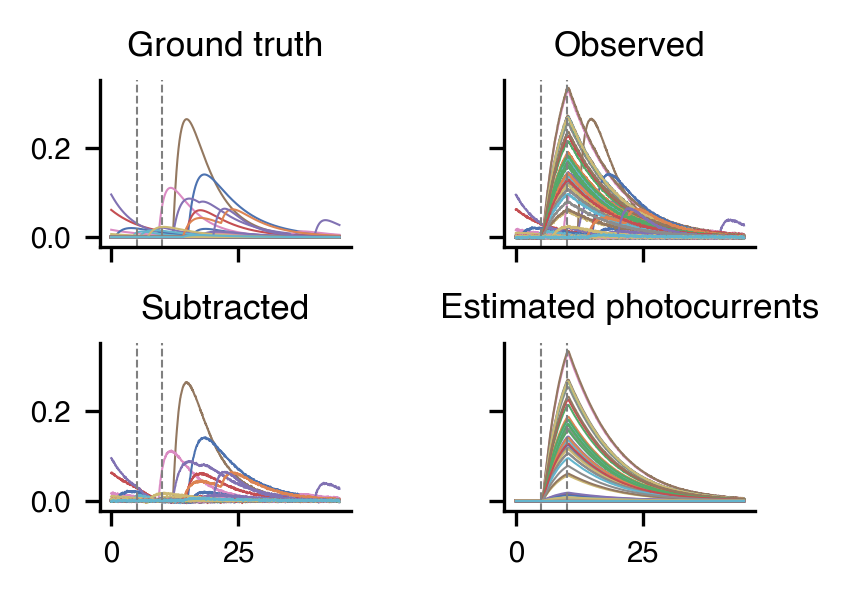

In [5]:
# plot original, true, and estimated
fig, axs = plt.subplots(2, 2, figsize=(3,2), dpi=300, sharey=True, sharex=True)

utils.plot_current_traces(true_synaptic, ax=axs[0,0], scalebar=False)
utils.plot_current_traces(observed, ax=axs[0,1], scalebar=False)
utils.plot_current_traces(subtracted, ax=axs[1,0], scalebar=False)
utils.plot_current_traces(est, ax=axs[1,1], scalebar=False)

axs[0,0].set_title('Ground truth')
axs[0,1].set_title('Observed')
axs[1,0].set_title('Subtracted')
axs[1,1].set_title('Estimated photocurrents')
plt.tight_layout()
plt.show()